Dependencies

In [1]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# STL Decomposition
from statsmodels.tsa.seasonal import STL

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, TimeDistributed
from tensorflow.keras.utils import plot_model

Load Dataset

In [2]:
df = pd.read_csv("/content/drive/MyDrive/ULTRAMAX RON 92/DATA/dataset_encoded.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1919 entries, 0 to 1918
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1919 non-null   object 
 1   Inflasi YoY    1919 non-null   float64
 2   Temp Avg       1919 non-null   float64
 3   Humidity Avg   1919 non-null   int64  
 4   RR             1919 non-null   float64
 5   Produksi BM    1919 non-null   float64
 6   Produksi BP    1919 non-null   float64
 7   Produksi CR    1919 non-null   float64
 8   Bawang Merah   1919 non-null   float64
 9   Bawang Putih   1919 non-null   float64
 10  Cabai Rawit    1919 non-null   float64
 11  is_tahun_baru  1919 non-null   int64  
 12  is_idul_fitri  1919 non-null   int64  
 13  is_natal       1919 non-null   int64  
dtypes: float64(9), int64(4), object(1)
memory usage: 210.0+ KB


Rename and Choose Columns

In [3]:
df = df.rename(columns={
    'Date': 'date',
    'Inflasi YoY': 'inflasi_yoy',
    'Temp Avg': 'temp',
    'Humidity Avg': 'humidity',
    'RR': 'rainfall',
    'Produksi BP': 'produksi_bp',
    'Bawang Putih': 'bawang_putih'
})

df = df[['date', 'inflasi_yoy', 'temp', 'humidity',
         'rainfall', 'produksi_bp', 'bawang_putih',
         'is_tahun_baru', 'is_idul_fitri', 'is_natal']]

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

STL Decomposition

In [4]:
df_stl = df.set_index('date')
stl = STL(df_stl['bawang_putih'], period=7)
result = stl.fit()
df_stl['trend'] = result.trend
df_stl['seasonal'] = result.seasonal
df_stl['residual'] = result.resid
df_stl = df_stl.reset_index()

Define 'Target Cols' and 'Feature Cols' and Scaling

In [6]:
# Gabungkan fitur
features = ['trend', 'seasonal', 'residual', 'inflasi_yoy',
            'temp', 'humidity', 'rainfall', 'produksi_bp',
            'is_tahun_baru', 'is_idul_fitri', 'is_natal']
target = ['bawang_putih']
data = df_stl[features + target].dropna()

# Scaling
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(data[features])
y_scaled = scaler_y.fit_transform(data[target])

Sequence Preparation

In [7]:
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

Build Model

In [8]:
input_layer = Input(shape=(window_size, X_seq.shape[2]))
lstm_out = LSTM(64, return_sequences=True)(input_layer)
attention_out = Attention()([lstm_out, lstm_out])
concat = Concatenate()([lstm_out, attention_out])
dense = TimeDistributed(Dense(32, activation='relu'))(concat)
output = Dense(1)(dense[:, -1, :])

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 30, 64)    │     19,456 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 30, 64)    │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 30, 128)   │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 30, 32)    │      4,128 │ concatenate[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 32)        │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ get_item[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,617 (92.25 KB)

 Trainable params: 23,617 (92.25 KB)

 Non-trainable params: 0 (0.00 B)

Train Model

In [9]:
history = model.fit(X_seq, y_seq, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0630 - val_loss: 0.0030
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0025 - val_loss: 8.5762e-04
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 7.8325e-04 - val_loss: 7.9474e-04
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.6992e-04 - val_loss: 0.0021
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.8393e-04 - val_loss: 8.7104e-04
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.7189e-04 - val_loss: 0.0014
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 1.8060e-04 - val_loss: 0.0013
Epoch 12/50
48/48 ━━━━━━━━━━━━━

Evaluation

In [10]:
y_pred_scaled = model.predict(X_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_seq)

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# MAE
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae:.2f}")

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.2f}")

# MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_value = mape(y_true, y_pred)
print(f"MAPE: {mape_value:.2f}%")

# R² Score
r2 = r2_score(y_true, y_pred)
print(f"R-squared: {r2:.3f}")

MAE: 198.86
RMSE: 345.10
MAPE: 0.53%
R-squared: 0.998


Visualization

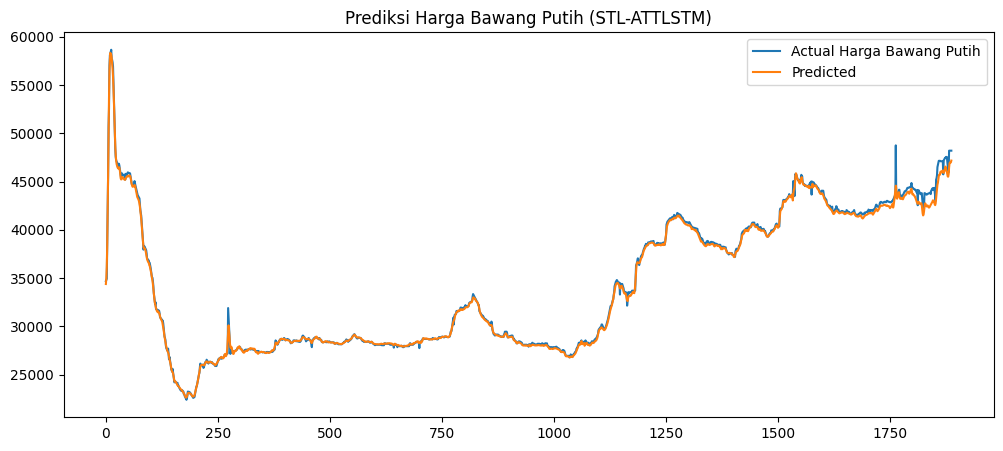

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Actual Harga Bawang Putih')
plt.plot(y_pred, label='Predicted')
plt.title("Prediksi Harga Bawang Putih (STL-ATTLSTM)")
plt.legend()
plt.show()

Save Model

In [13]:
model.save('bp_model.h5')

In [14]:
model.save('bp_model.keras')

Try to Forecast

In [15]:
n_hari = 14  # jumlah hari ke depan yang ingin diprediksi
forecast_input = X_scaled[-window_size:].copy()  # ambil window terakhir
forecast = []

for _ in range(n_hari):
    input_batch = forecast_input.reshape(1, window_size, -1)
    pred_scaled = model.predict(input_batch)[0][0]

    # Buat input baru untuk next step
    next_input = np.append(forecast_input[1:], [[*forecast_input[-1][:-1], pred_scaled]], axis=0)
    forecast_input = next_input
    forecast.append(pred_scaled)

# Inverse transform hasil forecast
forecast_inverse = scaler_y.inverse_transform(np.array(forecast).reshape(-1, 1))

# Tampilkan hasil prediksi
tanggal_awal = df_stl['date'].iloc[-1] + pd.Timedelta(days=1)
tanggal_prediksi = pd.date_range(start=tanggal_awal, periods=n_hari)

forecast_df = pd.DataFrame({
    'tanggal': tanggal_prediksi,
    'prediksi_harga_bawang_putih': forecast_inverse.flatten()
})

print("\n📅 Prediksi Harga Bawang Putih ({} hari ke depan):".format(n_hari))
print(forecast_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

📅 Prediksi Harga Bawang Putih (14 hari ke depan):
      tanggal  prediksi_harga_bawang_putih
0  2025-04-01                 46775.769531
1  2025-04-02                 46603.113281
2  2025-04-03                 46236.105469
3  2025-04-04                 46048.472656
4  2025-04-05                 46047.402344
5  2025-04-06                 46163.453125
6  2025-04-07                 46388.585938
7  2025-04-08                 46655.750000
8  2025-04-09                 